<a href="https://colab.research.google.com/github/michelucci/aadl2-code/blob/master/chapter6/Object_Localization_dumb_sliding_window_MNIST_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object localization built with a sliding window

Created on 16/5/2019 14:40

(C) Umberto Michelucci

umberto.michelucci@toelt.ai

www.toelt.ai

Umberto is author of the book "**Applied Deep Learning
A Case-Based Approach to Understanding Deep Neural Networks**" published by APRESS end of 2018. You can buy this book here

[toe.lt/book](http://toe.lt/book)


**Note** this is not the way to do object localization but it is very instructive to understand what it is and why you should not do it this way.

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches

Using TensorFlow backend.


In [0]:
plt.rcParams['axes.facecolor'] = 'white'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
model_path = '/content/drive/My Drive/pretrained-models/model_mnist.json'
weights_path = '/content/drive/My Drive/pretrained-models/model_mnist.h5'

json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


In [0]:
from keras.utils import np_utils # To transform labels in categorical
from keras.datasets import mnist # To load the dataset
from keras import backend as K
import keras
K.set_image_dim_ordering('tf') # To tell TensorFlow the right order of dims

# if using google colab and wants to upload or download files
from google.colab import files

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [8]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples


In [0]:
nClasses = 10
y_train = np_utils.to_categorical(y_train,nClasses)
y_test = np_utils.to_categorical(y_test,nClasses)

In [10]:
loaded_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 99.28%


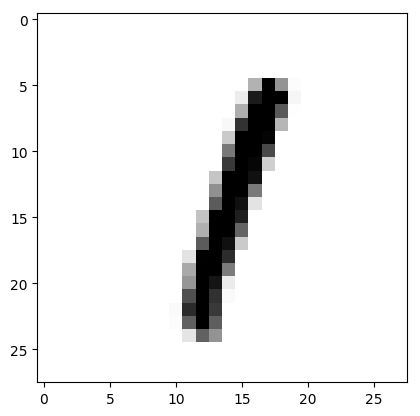

In [11]:
plt.style.use('default')
plt.imshow(x_test[5].reshape(28,28), cmap = "gray_r")

In [12]:
np.round(loaded_model.predict(x_test[5].reshape(1,28,28,1)))

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Enlarging the image

In [0]:
from PIL import Image, ImageOps
src_img = Image.fromarray(x_test[5].reshape(28,28))
newimg = ImageOps.expand(src_img,border=56,fill='black')

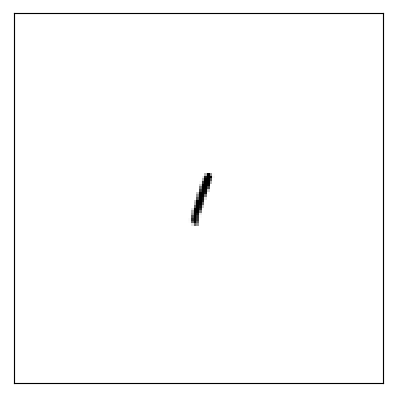

In [14]:
#plt.xscale(0,140)
fig = plt.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])

plt.savefig('temp.eps')
files.download('temp.eps')

In [0]:
bigimg = np.array(newimg)
print(bigimg.shape)

(140, 140)


# Localization of the digit

Now we extract a $28\times28$ sliding window starting from the top left with a stride of 10 and we pass this image to our network and we will keep only the one with the highest proability of a digit.

In [0]:
(140-28)//10

11

In [0]:
def localize_digit(bigimg, stride, wx, wy):
  slidx, slidy = wx, wy

  digit_found = -1
  max_prob = -1
  bbx = -1 # Bounding box x upper left
  bby = -1 # Bounding box y upper left
  max_prob_ = 0.0
  bbx_ = -1
  bby_ = -1
  most_prob_digit = -1
  
  
  
  maxloopx = (bigimg.shape[0] -wx) // stride
  maxloopy = (bigimg.shape[1] -wy) // stride
  
  for slicey in range (0, maxloopx*stride, stride):
    for slicex in range (0, maxloopy*stride, stride):
      slice_ = bigimg[slicex:slicex+wx, slicey:slicey+wx]
      #probs = loaded_model.predict(slice_.reshape(1,28,28,1))
      img_ = Image. fromarray(slice_).resize((28, 28), Image.NEAREST) 
      probs = loaded_model.predict(np.array(img_).reshape(1,28,28,1))
      if (np.max(probs > 0.1)):
        most_prob_digit = np.argmax(probs)
        max_prob_ = np.max(probs)
        bbx_ = slicex
        bby_ = slicey

      if (max_prob_ > max_prob):
        max_prob = max_prob_
        bbx = bbx_
        bby = bby_
        digit_found = most_prob_digit
        print("Digit "+str(digit_found)+ " found, with probability "+str(max_prob)+" at coordinates "+str(bbx)+" "+str(bby))
      
        
        
  print("Digit "+str(digit_found)+ " found, with probability "+str(max_prob)+" at coordinates "+str(bbx)+" "+str(bby))
      
        
  return (max_prob, bbx, bby, digit_found)

In [50]:
localize_digit(np.array(newimg), 10, 10, 10)

Digit 1 found, with probability 0.15846781 at coordinates 0 0
Digit 1 found, with probability 0.16165628 at coordinates 60 60
Digit 1 found, with probability 0.24568161 at coordinates 70 60
Digit 0 found, with probability 0.3487859 at coordinates 60 70
Digit 0 found, with probability 0.3487859 at coordinates 60 70


(0.3487859, 60, 70, 0)

Digit 1 found, with probability 0.15846781 at coordinates 0 0
Digit 1 found, with probability 0.16165628 at coordinates 60 60
Digit 1 found, with probability 0.24568161 at coordinates 70 60
Digit 0 found, with probability 0.3487859 at coordinates 60 70
Digit 0 found, with probability 0.3487859 at coordinates 60 70


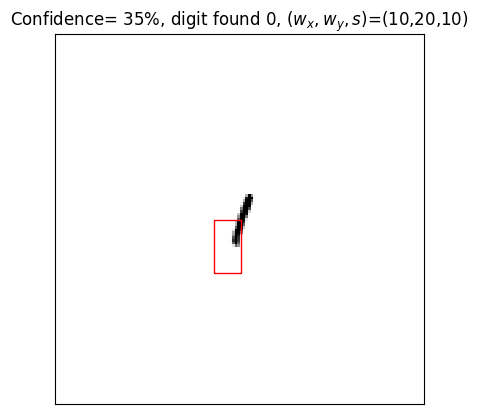

In [55]:
wx = 10
wy = 20
s = 10
max_prob, bbx, bby, digit_found = localize_digit(np.array(newimg), wx, wx, s)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('Confidence= %1.0f%%, digit found %i, ' % (max_prob*100, digit_found)+ "($w_x,w_y,s$)=(%d,%d,%d)" % (wx,wy,s))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])
rect = patches.Rectangle((bbx,bby),wx,wy,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.savefig('temp.eps')
files.download('temp.eps')

(11, 11)
Digit -1 Slice -1 -1 with prob: 0.0
Digit 7 Slice 50 50 with prob: 0.48507714
Digit 1 Slice 60 50 with prob: 0.56485534
Digit 1 Slice 50 60 with prob: 0.9932834
Digit 1 found, with probability 0.9932834 at coordinates 50 60


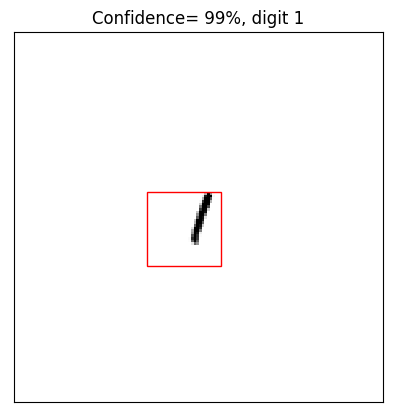

<Figure size 640x480 with 0 Axes>

In [0]:
max_prob, bbx, bby, digit_found = localize_digit(10)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('Confidence= %1.0f%%, digit %i' % (max_prob*100, digit_found))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])
rect = patches.Rectangle((bbx,bby),28,28,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

plt.savefig('temp.eps')
files.download('temp.eps')

(112, 112)
Digit -1 Slice -1 -1 with prob: 0.0
Digit 1 Slice 65 47 with prob: 0.48799554
Digit 1 Slice 66 47 with prob: 0.5244411
Digit 1 Slice 56 48 with prob: 0.5460636
Digit 7 Slice 53 49 with prob: 0.6775942
Digit 7 Slice 54 49 with prob: 0.7262383
Digit 4 Slice 58 49 with prob: 0.7894856
Digit 7 Slice 53 50 with prob: 0.8688422
Digit 7 Slice 52 51 with prob: 0.87271345
Digit 7 Slice 53 51 with prob: 0.9200312
Digit 7 Slice 52 52 with prob: 0.9333025
Digit 1 Slice 61 52 with prob: 0.9342514
Digit 7 Slice 51 53 with prob: 0.9670183
Digit 7 Slice 52 53 with prob: 0.9815351
Digit 1 Slice 57 53 with prob: 0.99559844
Digit 1 Slice 58 53 with prob: 0.9976299
Digit 1 Slice 62 53 with prob: 0.99775875
Digit 1 Slice 56 54 with prob: 0.9991392
Digit 1 Slice 57 54 with prob: 0.999972
Digit 1 Slice 58 54 with prob: 0.9999924
Digit 1 Slice 56 55 with prob: 0.9999976
Digit 1 Slice 57 55 with prob: 1.0
Digit 1 found, with probability 1.0 at coordinates 57 55


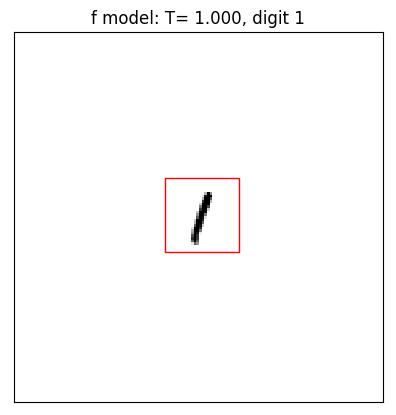

<Figure size 640x480 with 0 Axes>

In [0]:
max_prob, bbx, bby, digit_found = localize_digit(1)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('f model: T= %1.3f, digit %i' % (max_prob, digit_found))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])
rect = patches.Rectangle((bbx,bby),28,28,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

plt.savefig('temp.eps')
files.download('temp.eps')

(4, 4)
Digit -1 Slice -1 -1 with prob: 0.0
Digit 7 Slice 50 50 with prob: 0.48507714
Digit 7 found, with probability 0.48507714 at coordinates 50 50


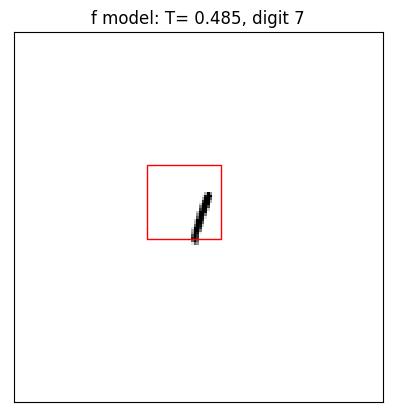

<Figure size 640x480 with 0 Axes>

In [0]:
max_prob, bbx, bby, digit_found = localize_digit(25)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('f model: T= %1.3f, digit %i' % (max_prob, digit_found))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])
rect = patches.Rectangle((bbx,bby),28,28,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

plt.savefig('temp.eps')
files.download('temp.eps')

(12, 12)
Digit -1 Slice -1 -1 with prob: 0.0
Digit 7 Slice 54 54 with prob: 0.61147135
Digit 1 Slice 63 54 with prob: 0.9996916
Digit 1 found, with probability 0.9996916 at coordinates 63 54


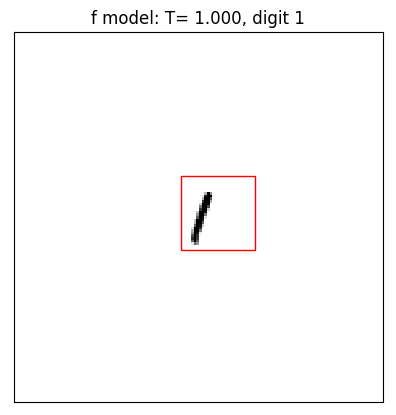

<Figure size 640x480 with 0 Axes>

In [0]:
max_prob, bbx, bby, digit_found = localize_digit(9)

fig,ax = plt.subplots(1)

# Display the image
ax.set_title('f model: T= %1.3f, digit %i' % (max_prob, digit_found))
ax.imshow(newimg, cmap = "gray_r")
plt.axis('on')
plt.xticks([])
plt.yticks([])
rect = patches.Rectangle((bbx,bby),28,28,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

plt.savefig('temp.eps')
files.download('temp.eps')